In [2]:
!pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 4.5 MB/s eta 0:00:00
  Using cached DateTime-5.1-py3-none-any.whl (52 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 7.1 MB/s eta 0:00:00
  Using cached multipledispatch-0.6.0-py3-none-any.whl (11 kB)
  Using cached zope.interface-6.0-cp310-cp310-macosx_11_0_arm64.whl (202 kB)


In [3]:
import pandas as pd
import numpy as np
import os

from pykrx import stock 
import datetime

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('font', family='Malgun Gothic')
mpl.__version__


'3.7.1'

In [4]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)


## DataSet 준비 

In [5]:
start = '20150101'
end = '20211231'
year = 1 

stock_names = ['Samsung', 'SkHynix', 'LG Chemical', 'NAVER', 'Hyundai Car', 'Samsung SDI', 'KAKAO' ]
stock_codes = ['005930', '000660', '051910', '035420', '005380', '006400', '035720']

list = []
for code in stock_codes:

    Close= stock.get_market_ohlcv_by_date(start, end, code)
    list.append(pd.DataFrame(Close['종가']))

Close_df = pd.concat(list, axis=1)
Close_df.columns = [stock_names]
Close_df.head(10)

,Samsung,SkHynix,LG Chemical,NAVER,Hyundai Car,Samsung SDI,KAKAO
날짜,,,,,,,
2015-01-02,1330000,47750,180000,731000,169000,117000,137200
2015-01-05,1333000,47650,174500,749000,168000,115000,144500
2015-01-06,1295000,47500,166000,743000,164500,111000,145300
2015-01-07,1307000,47400,164500,732000,170000,110500,148200
2015-01-08,1314000,49950,168000,744000,178000,114000,147300
2015-01-09,1314000,49700,178500,752000,180000,115500,149500
2015-01-12,1316000,50300,180500,750000,177500,116000,145400
2015-01-13,1339000,49000,180000,740000,179500,113500,142600
2015-01-14,1345000,48900,177500,739000,177500,112000,144400


# Feature Engineering

In [6]:
returns =Close_df.pct_change()

def get_monthly_returns_df (Close_df, start, end):
    
    returns = Close_df.pct_change()
    returns_monthly = (1+returns).resample('M').agg('prod') - 1
    returns_monthly = returns_monthly.loc[start:end] 
    returns_monthly = returns_monthly.dropna()
    
    return returns_monthly

start = '2015-01' 
end= '2021-12'



returns_monthly = get_monthly_returns_df(Close_df, start, end)

returns_monthly.head(5)



,Samsung,SkHynix,LG Chemical,NAVER,Hyundai Car,Samsung SDI,KAKAO
날짜,,,,,,,
2015-01-31,0.026316,-0.002094,0.102778,-0.020518,0.002959,1.025641e-01,0.112971
2015-02-28,-0.005861,-0.022036,0.158690,-0.076818,-0.053097,5.813953e-02,-0.128357
2015-03-31,0.061901,-0.022532,-0.017391,0.015130,0.049844,4.440892e-16,-0.132996
2015-04-30,-0.021513,0.013172,0.207965,-0.031297,0.002967,-1.208791e-01,-0.064977
2015-05-31,-0.073050,0.107259,-0.086081,-0.063072,-0.065089,2.083333e-02,0.087131


## MVO 최소분산포트폴리오 

In [7]:
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 226.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.2 MB/s eta 0:00:00


In [8]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [9]:
ann_mean_return = returns_monthly.mean() * 252
cov = returns_monthly.cov() 

In [10]:
# Sharpe Ratio 최적화 진행 

Ef_Front = EfficientFrontier(ann_mean_return, cov)
weights = Ef_Front.max_sharpe()
print(weights)
cleaned_weights = Ef_Front.clean_weights()
print(cleaned_weights)
Ef_Front.portfolio_performance(verbose=True)

OrderedDict([(('Samsung',), 0.2525148921653162), (('SkHynix',), 0.1908185974599038), (('LG Chemical',), 0.1061663765983743), (('NAVER',), 0.0517125354362812), (('Hyundai Car',), 0.0), (('Samsung SDI',), 0.2182170301485059), (('KAKAO',), 0.1805705681916186)])
OrderedDict([(('Samsung',), 0.25251), (('SkHynix',), 0.19082), (('LG Chemical',), 0.10617), (('NAVER',), 0.05171), (('Hyundai Car',), 0.0), (('Samsung SDI',), 0.21822), (('KAKAO',), 0.18057)])
Expected annual return: 492.6%
Annual volatility: 5.8%
Sharpe Ratio: 85.30


(4.925656978447144, 0.05751152767304456, 85.29867275193956)

In [11]:
weights = dict(weights)
Ef_weights = [weights[k] for k in weights.keys()]
Ef_weights

[0.2525148921653162,
 0.1908185974599038,
 0.1061663765983743,
 0.0517125354362812,
 0.0,
 0.2182170301485059,
 0.1805705681916186]

In [12]:
ann_port_return = (returns_monthly.mean() * Ef_weights).sum() * 252

In [13]:
returns_monthly.index[0]
returns_monthly.index[23]

returns_monthly.index[24]

len(returns_monthly.index) - 24

60

In [14]:
len(returns_monthly.index) / 3

28.0

In [15]:
# t=24 -> t+1 
# 3개월마다 rebalancing 진행 

rebalanced_return_list = []
rebalanced_weight_list = []
rebalanced_index_list = []

for i in range(int((len(returns_monthly.index) - 24)/ 3) ):
    
    index = returns_monthly.index
    returns = returns_monthly[index[i*3] : index[i*3+24]]
    
    
    ann_mean_return = returns.mean() * 252
    cov = returns.cov() 
    
    Ef_Front = EfficientFrontier(ann_mean_return, cov)
    weights = Ef_Front.max_sharpe()
    weights = dict(weights)
    Ef_weights = [weights[k] for k in weights.keys()]
    
    ann_port_return = (returns_monthly.mean() * Ef_weights).sum() * 252
    
    rebalanced_index_list.append(index[i*3 + 24])
    rebalanced_return_list.append(ann_port_return)
    rebalanced_weight_list.append(Ef_weights)

In [16]:
df_reb_return = pd.DataFrame(rebalanced_return_list, index=rebalanced_index_list, columns = ['return'])
df_reb_weight = pd.DataFrame(rebalanced_weight_list, index=rebalanced_index_list, columns = returns_monthly.columns)

In [17]:
df_reb_return

,return
2017-01-31,4.227633
2017-04-30,4.137304
2017-07-31,3.997843
2017-10-31,4.456759
2018-01-31,4.482799
2018-04-30,4.479637
2018-07-31,4.803263
2018-10-31,5.509322
2019-01-31,5.616116
2019-04-30,5.511536


In [18]:
df_reb_weight

,Samsung,SkHynix,LG Chemical,NAVER,Hyundai Car,Samsung SDI,KAKAO
2017-01-31,0.510670,0.189933,0.299397,0.000000,0.00000,0.000000,0.000000
2017-04-30,0.631624,0.160890,0.181188,0.000000,0.00000,0.000000,0.026299
2017-07-31,0.503563,0.116762,0.000000,0.000000,0.15592,0.052496,0.171259
2017-10-31,0.335397,0.227193,0.000000,0.192246,0.00000,0.148474,0.096690
2018-01-31,0.378282,0.220552,0.054010,0.123049,0.00000,0.149958,0.074150
2018-04-30,0.314323,0.378329,0.000000,0.001286,0.05054,0.245720,0.009802
2018-07-31,0.070499,0.491124,0.126396,0.028453,0.00000,0.239689,0.043839
2018-10-31,0.137690,0.252481,0.000000,0.000000,0.00000,0.609829,0.000000
2019-01-31,0.000000,0.295678,0.063609,0.000000,0.00000,0.564212,0.076501
2019-04-30,0.000000,0.356922,0.000000,0.000000,0.00000,0.498147,0.144931


# Rebalancing Return Performance Evaluation

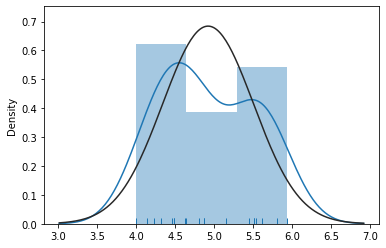

In [19]:
import seaborn as sns
import scipy as sp 

sns.distplot(rebalanced_return_list, kde=True, rug= True, fit=sp.stats.norm)
sns.set(rc={'figure.figsize':(20,20)})

### Performance Evaluation를 위해 monthly weights, return으로 변환 

In [20]:
weights_for_perf = pd.DataFrame(index=returns_monthly.index[24:], columns=returns_monthly.columns)

In [21]:
a=0
for i in range(len(weights_for_perf.index)):
    
    if i == 0 :
        weights_for_perf.iloc[i] = df_reb_weight.iloc[0]
    
    elif i%3 != 0:
        weights_for_perf.iloc[i] = df_reb_weight.iloc[a]
    
    elif i%3 == 0 :
        a += 1
        weights_for_perf.iloc[i] = df_reb_weight.iloc[a]
        
        

In [22]:
weights_for_perf 

,Samsung,SkHynix,LG Chemical,NAVER,Hyundai Car,Samsung SDI,KAKAO
날짜,,,,,,,
2017-01-31,0.51067,0.189933,0.299397,0.0,0.0,0.0,0.0
2017-02-28,0.51067,0.189933,0.299397,0.0,0.0,0.0,0.0
2017-03-31,0.51067,0.189933,0.299397,0.0,0.0,0.0,0.0
2017-04-30,0.631624,0.16089,0.181188,0.0,0.0,0.0,0.026299
2017-05-31,0.631624,0.16089,0.181188,0.0,0.0,0.0,0.026299
2017-06-30,0.631624,0.16089,0.181188,0.0,0.0,0.0,0.026299
2017-07-31,0.503563,0.116762,0.0,0.0,0.15592,0.052496,0.171259
2017-08-31,0.503563,0.116762,0.0,0.0,0.15592,0.052496,0.171259
2017-09-30,0.503563,0.116762,0.0,0.0,0.15592,0.052496,0.171259


In [23]:
return_for_perf = []

for i in range(len(weights_for_perf)): 
    perf_return = weights_for_perf.iloc[i] * returns_monthly.loc[weights_for_perf.index[i]]
    perf_return = perf_return.sum()
    return_for_perf.append(perf_return)

In [24]:
return_for_perf_df = pd.DataFrame(return_for_perf, index= weights_for_perf.index, columns= ['return'])
return_for_perf_df

,return
날짜,
2017-01-31,0.087848
2017-02-28,-0.013961
2017-03-31,0.063758
2017-04-30,0.053566
2017-05-31,0.031030
2017-06-30,0.063605
2017-07-31,0.020695
2017-08-31,-0.006876
2017-09-30,0.119133


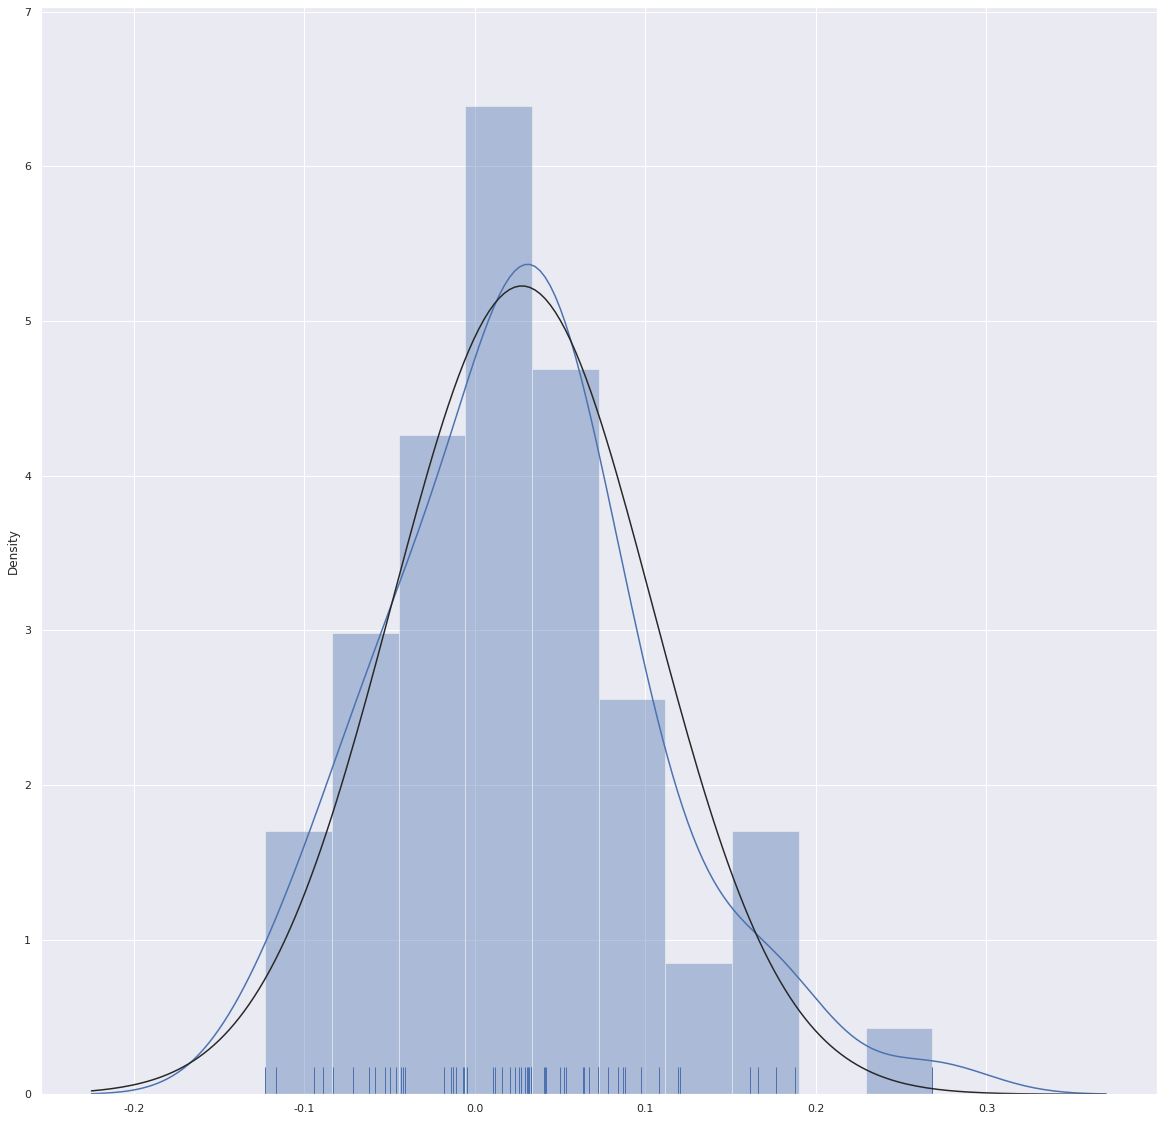

In [25]:
import seaborn as sns
import scipy as sp 

sns.distplot(return_for_perf_df, kde=True, rug= True, fit=sp.stats.norm)
sns.set(rc={'figure.figsize':(20,20)})

In [26]:
# MDD, CVaR, Ratios 등 Performance Evaluation 추가적으로 진행 